Here we will perform face recognition task.\
It will be splitted into several parts: face detection, face aligment, feature extraction and face recognition.\
More detailes about each part further

# DATASET MANIPULATION

In [1]:
!pip install facenet-pytorch opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 66.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import cv2
import random
import matplotlib.image as mpimg
import plotly.express as px
from PIL import Image
from facenet_pytorch import MTCNN
import torch

I chose this [dataset](https://www.kaggle.com/datasets/hereisburak/pins-face-recognition/data) cause of several reasons:
* 17k overall amount of pictures present
* 105 different classes
* 100-150 pictures for each class on average
* some images are blurry, with some kind of objects on people faces etc

All this points make this dataset stand out among others, cause it is more suitable for the situations where face recognition is used(companies entrances(more straightforward clear images), cameras(maybe blurry and noisy images) etc)

Let's inspect this dataset more by checking total amount of images for each class

In [3]:
root_path = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/'

dir_names = os.listdir(root_path)
person_names = [name.split("_")[-1].title() for name in dir_names]
n_individuals = len(person_names)

print(f"Total number of individuals: {n_individuals}")

n_images_per_person = [len(os.listdir(root_path + name)) for name in dir_names]
n_images = sum(n_images_per_person)

print(f"Total Number of Images : {n_images}.")
print(f'Lowest size class: {min(n_images_per_person)}')
print(f'Highest size class: {max(n_images_per_person)}')

Total number of individuals: 105
Total Number of Images : 17534.
Lowest size class: 86
Highest size class: 237


Now it's important to understand, that just like in classification problems classes should be balanced, but it's not as crusial, so let's visualize the distribution

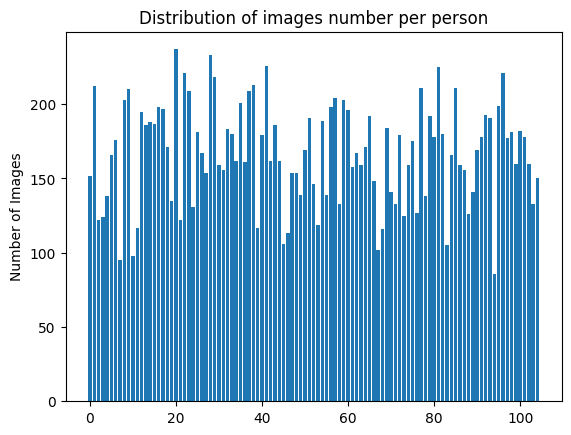

In [4]:
plt.bar(range(len(n_images_per_person)), n_images_per_person)
plt.ylabel('Number of Images')
plt.title('Distribution of images number per person')
plt.show()

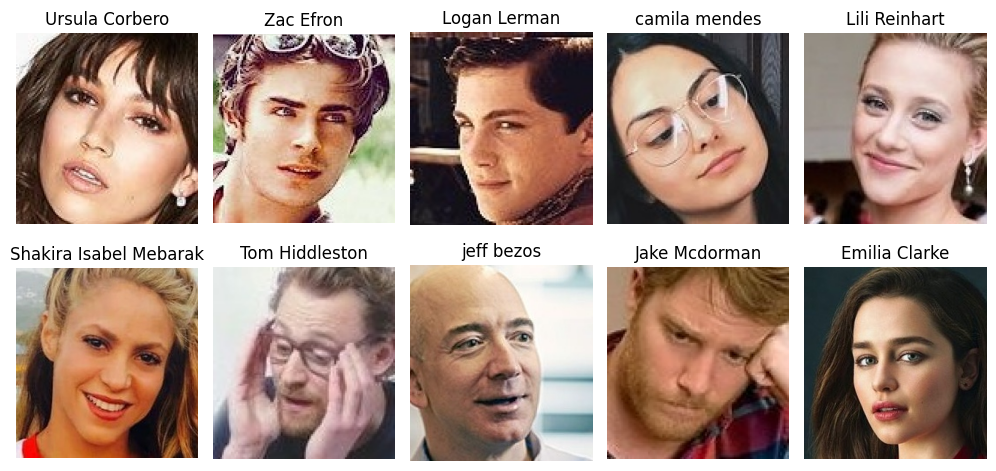

In [4]:
selected_folders = random.sample(dir_names, 10)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, folder in enumerate(selected_folders):
    folder_path = os.path.join(root_path, folder)
    all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

    selected_image = random.choice(all_images)

    image_path = os.path.join(folder_path, selected_image)

    img = mpimg.imread(image_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')

    label = folder[5:]
    axes[i // 5, i % 5].set_title(label)

plt.tight_layout()
plt.show()

# FACE DETECTION & FACE ALIGMENT

Here we'll actually perform both face detection and face aligment.

*Detection*\
Objective is to analyze the image and surround the face with the bounding box.\
Important to understand that this part only tells us if the face is present on an image, nothing more.

*ALigment*\
Objective is to use key points of the face to rotate image in default position and also crop unnecessary part of the image.

*Both detection and aligment*\
To make this happen, we'll use MTCNN, which is a hand implementation using FaceNet MTCNN as reference.\
It will provide us with both bounding boxes and key points, which then would be used to apply affine transformations.

In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [68]:
mtcnn = MTCNN(keep_all=True, device=device)

In [69]:
input_dir = '/kaggle/input/pins-face-recognition/105_classes_pins_dataset/' 
output_dir = '/kaggle/working/cropped' 

os.makedirs(output_dir, exist_ok=True)

In [5]:
# Function to apply affine transformation
def align_face(image, landmarks):
    # Extract eye coordinates
    left_eye = landmarks[0]
    right_eye = landmarks[1]
    
    # Compute the center of the eyes
    eye_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)
    
    # Compute the angle of rotation based on the eye position
    delta_x = right_eye[0] - left_eye[0]
    delta_y = right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(delta_y, delta_x))

    # Get the rotation matrix for affine transformation
    rotation_matrix = cv2.getRotationMatrix2D(eye_center, angle, 1)
    
    # Perform the affine transformation (rotating and scaling)
    aligned_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

    return aligned_image

In [74]:
for person_folder in os.listdir(input_dir):
    person_dir = os.path.join(input_dir, person_folder)
    
    if os.path.isdir(person_dir):
        person_output_dir = os.path.join(output_dir, person_folder)
        os.makedirs(person_output_dir, exist_ok=True)

        for image_name in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_name)

            image = Image.open(image_path)
            image_np = np.array(image)

            boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

            if boxes is not None:
                for i, box in enumerate(boxes):
                    
                    box = box.astype(int)   
                    cropped_face = image_np[box[1]:box[3], box[0]:box[2]]
                    
                    try:
                        aligned_image_np = align_face(cropped_face, landmarks[i])
                    except:
                        continue
                    
                    cropped_aligned_face_pil = Image.fromarray(aligned_image_np)

                    aligned_face_path = os.path.join(person_output_dir, f'aligned_{image_name}')
                    try:
                        cropped_aligned_face_pil.save(aligned_face_path)
                    except:
                        continue

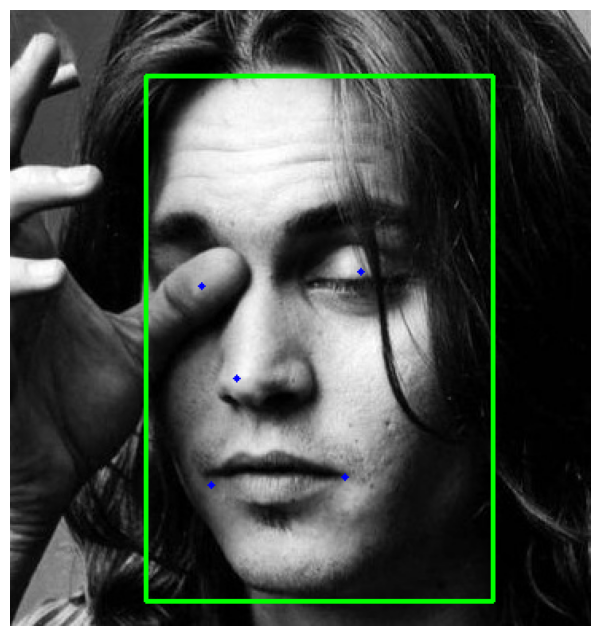

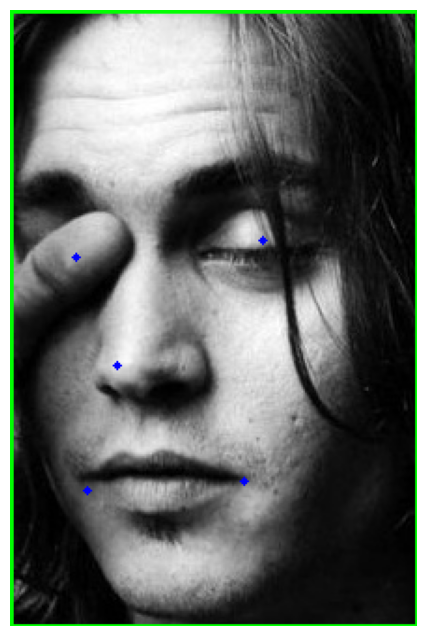

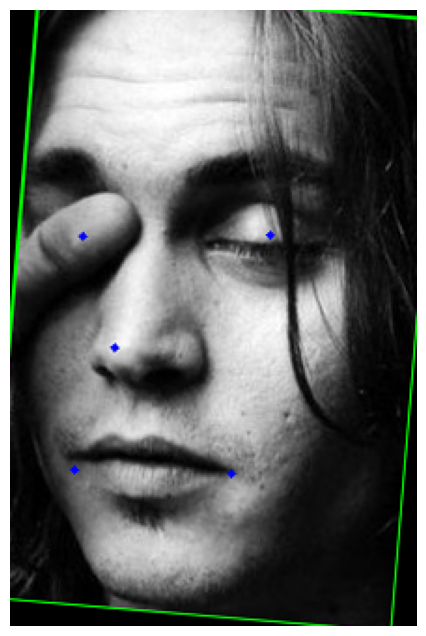

In [6]:
def display_aligned_cropped(image_path, show_result=False):
    mtcnn = MTCNN(keep_all=True, device=device)
    image = Image.open(image_path)

    boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)
    image_np = np.array(image)

    if boxes is not None:
        for i, box in enumerate(boxes):
            if show_result:  
                cv2.rectangle(image_np, 
                              (int(box[0]), int(box[1])), 
                              (int(box[2]), int(box[3])), 
                              (0, 255, 0), 2)  # Green box

                for landmark in landmarks[i]:
                    cv2.circle(image_np, (int(landmark[0]), int(landmark[1])), 2, (0, 0, 255), -1)

            box = box.astype(int)   
            cropd_face = image_np[box[1]:box[3], box[0]:box[2]]

            aligned_image_np = align_face(cropd_face, landmarks[i])
    if show_result:
        plt.figure(figsize=(8, 8))
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(8, 8))
        plt.imshow(cropd_face)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(8, 8))
        plt.imshow(aligned_image_np)
        plt.axis('off')
        plt.show()
        
    return aligned_image_np

_ = display_aligned_cropped('/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Johnny Depp/Johnny Depp112_1776.jpg', show_result=True)

Here we can see an example of MTCNN work, where it draws bounding box over detected face and blue dots over key face landmark points.

Let's save our cropped and alinged images in separate folder

In [84]:
import shutil

output_path = '/kaggle/working/cropped'
output_tar = '/kaggle/working/cropped_dataset'
shutil.make_archive(output_tar.replace('.tar.gz', ''), 'gztar', output_path)

print(f"Archive created at {output_tar}")

Archive created at /kaggle/working/distractor_cropped


Here are some examples of newly achieved images

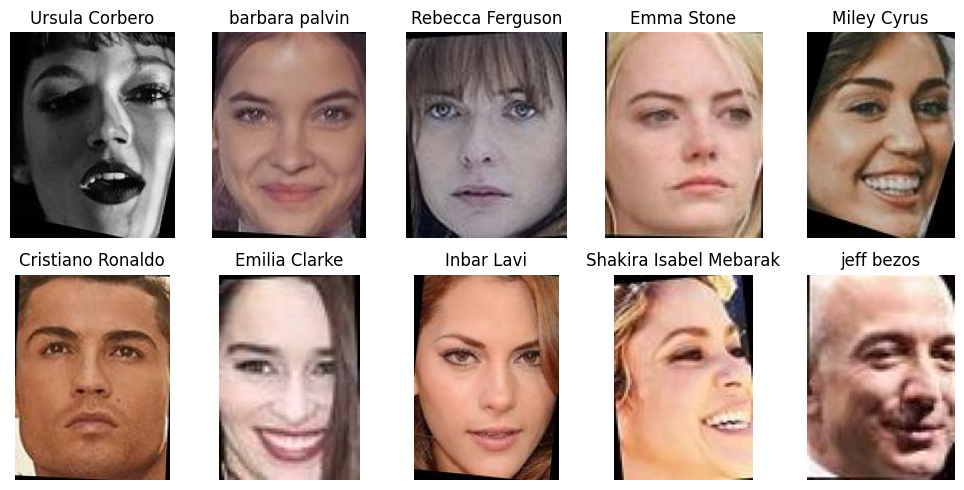

In [7]:
dir_names = os.listdir('/kaggle/input/cropped-dataset-latest/')
root_path = '/kaggle/input/cropped-dataset-latest/'
selected_folders = random.sample(dir_names, 10)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, folder in enumerate(selected_folders):
    folder_path = os.path.join(root_path, folder)
    all_images = [img for img in os.listdir(folder_path) if img.endswith('.jpg')]

    selected_image = random.choice(all_images)

    image_path = os.path.join(folder_path, selected_image)

    img = mpimg.imread(image_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis('off')

    label = folder[5:]
    axes[i // 5, i % 5].set_title(label)

plt.tight_layout()
plt.show()

# FEATURE EXTRACTION

For this part, objective is to acquire embbedings vectors from each image, to further use in face recognition part.\
For this we'll use EfficientNet_b1.\
Data will be splitted into train and dev parts as 85% to 15% ratio 

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import accuracy_score
import time
import torch.nn.functional as F
from shutil import copy2
from torchvision.models import efficientnet_b0, efficientnet_b1
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math
from torchvision.models import resnet18
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
import shutil
from torchvision.datasets import ImageFolder
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

In [62]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
def split_data(dataset_path, output_path, train_ratio=0.85, val_ratio=0.15, seed=42):
    random.seed(seed)
    classes = os.listdir(dataset_path)

    for split in ['train', 'val']:
        os.makedirs(f'{output_path}/{split}', exist_ok=True)

    for class_name in classes:
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        
        images = os.listdir(class_dir)
        images = [img for img in images if img.endswith(('jpg', 'png', 'jpeg'))]
        random.shuffle(images)
        
        train_count = int(train_ratio * len(images))
        
        train_images = images[:train_count]
        val_images = images[train_count:]

        for img in train_images:
            os.makedirs(f'{output_path}/train/{class_name}', exist_ok=True)
            copy2(os.path.join(class_dir, img), f'{output_path}/train/{class_name}/{img}')
        
        for img in val_images:
            os.makedirs(f'{output_path}/val/{class_name}', exist_ok=True)
            copy2(os.path.join(class_dir, img), f'{output_path}/val/{class_name}/{img}')

In [10]:
dataset_path = '/kaggle/input/cropped-dataset-latest'  
output_path = '/kaggle/working/'
split_data(dataset_path, output_path)

In [11]:
train_dataset = datasets.ImageFolder(root=f'{output_path}/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root=f'{output_path}/val', transform=val_transforms)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

In [13]:
print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

Training samples: 13598
Validation samples: 2457


Using CE as loss function

In [16]:
model_ce_b1 = efficientnet_b1(weights=None)
model_ce_b1.classifier[1] = nn.Linear(model_ce_b1.classifier[1].in_features, n_individuals)
model_ce_b1 = model_ce_b1.to(device)

We are using NOT pretrained model. Cause of that, wo achieve the best results with this amount of data, we need to use  
- scheduler
- weight decay
- data augmentation

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ce_b1.parameters(), lr=0.001, weight_decay=1e-4) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [14]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

early_stopping = EarlyStopping(patience=7, min_delta=1e-4)

In [19]:
def train_one_epoch(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    return train_loss, train_accuracy

In [20]:
def validate_one_epoch(model, criterion, val_loader, device):
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    return val_loss, val_accuracy

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, early_stopping=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_accuracy = train_one_epoch(model, criterion, optimizer, train_loader, device)
        
        val_loss, val_accuracy = validate_one_epoch(model, criterion, val_loader, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"Time: {time.time() - start_time:.2f}s")

        if early_stopping and early_stopping.should_stop(val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

In [22]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model_ce_b1, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=150, early_stopping=early_stopping
)

Epoch [1/150] Train Loss: 4.6587, Train Acc: 0.0153, Val Loss: 4.5663, Val Acc: 0.0240, Time: 89.32s
Epoch [2/150] Train Loss: 4.4708, Train Acc: 0.0254, Val Loss: 4.2440, Val Acc: 0.0362, Time: 89.11s
Epoch [3/150] Train Loss: 4.1257, Train Acc: 0.0451, Val Loss: 3.9048, Val Acc: 0.0672, Time: 89.20s
Epoch [4/150] Train Loss: 3.7437, Train Acc: 0.0852, Val Loss: 3.4631, Val Acc: 0.1298, Time: 89.59s
Epoch [5/150] Train Loss: 3.4188, Train Acc: 0.1402, Val Loss: 3.2470, Val Acc: 0.1697, Time: 89.18s
Epoch [6/150] Train Loss: 3.1222, Train Acc: 0.1958, Val Loss: 2.9791, Val Acc: 0.2239, Time: 89.34s
Epoch [7/150] Train Loss: 2.8413, Train Acc: 0.2571, Val Loss: 2.6266, Val Acc: 0.3053, Time: 89.35s
Epoch [8/150] Train Loss: 2.5874, Train Acc: 0.3159, Val Loss: 2.4747, Val Acc: 0.3451, Time: 89.88s
Epoch [9/150] Train Loss: 2.3656, Train Acc: 0.3721, Val Loss: 2.2209, Val Acc: 0.3997, Time: 90.03s
Epoch [10/150] Train Loss: 2.1511, Train Acc: 0.4262, Val Loss: 2.0507, Val Acc: 0.4343, Ti

In [23]:
torch.save(model_ce_b1.state_dict(), 'model_ce_b1.pth')

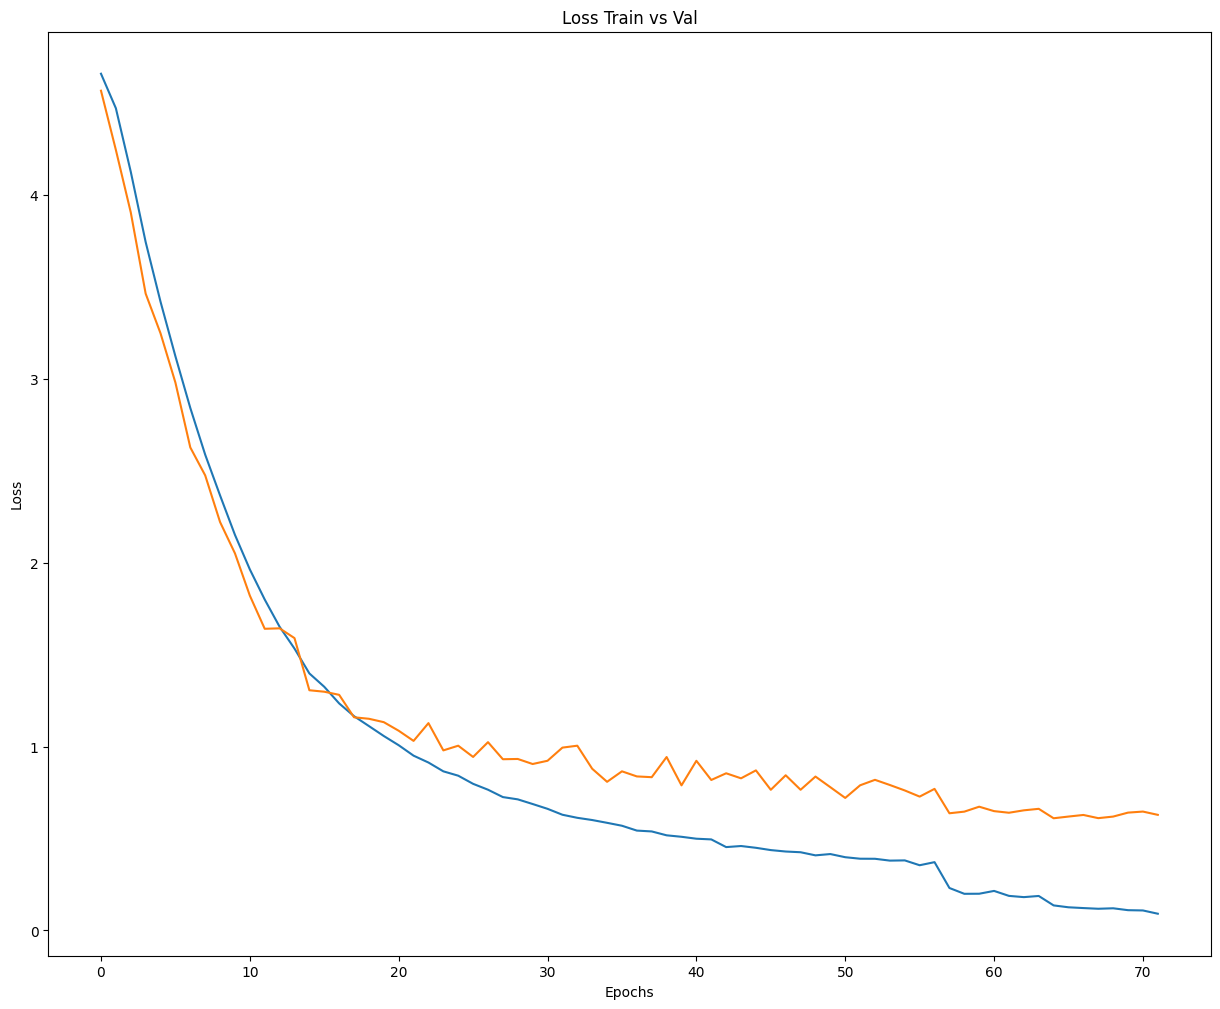

In [24]:
plt.figure(figsize=(15, 12))
plt.title('Loss Train vs Val')
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.plot(val_losses)
plt.ylabel('Loss')
plt.show()

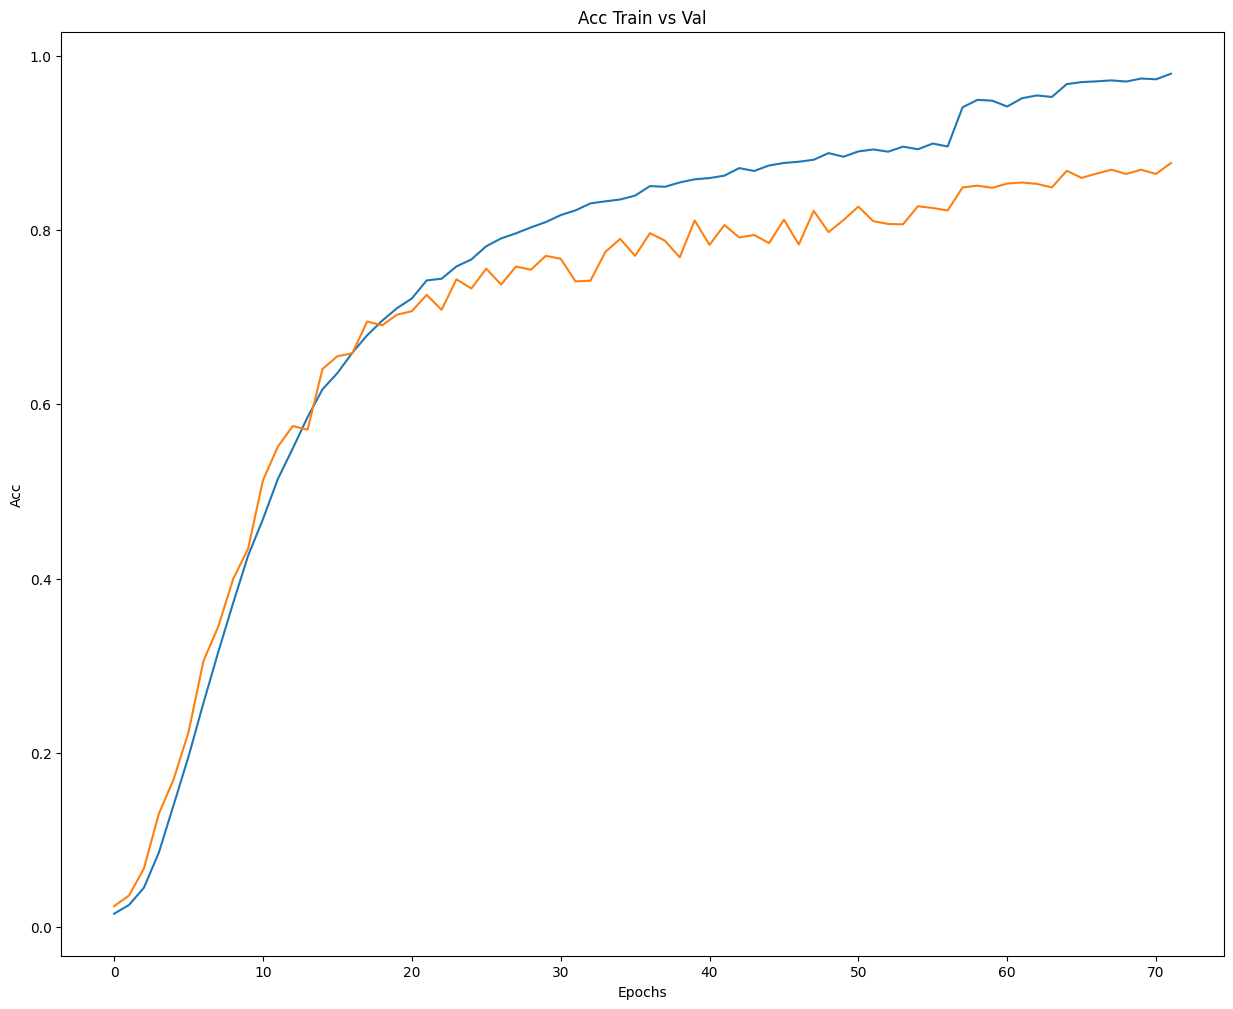

In [25]:
plt.figure(figsize=(15, 12))
plt.title('Acc Train vs Val')
plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.plot(val_accuracies)
plt.ylabel('Acc')
plt.show()

The results are not excellent, but considering that we using NOT pretrained model with such amount of data, we can call this moderate results.\
As can be seen from this comparison [analisys](https://medium.com/@bigamot01/human-face-classification-with-efficientnet-7edff2ad8fe5), with b1 model I already achieved peak results

Now we'll train new EfficienNet_b1 pretrained(on ImageNet dataset, not on specific face recognition dataset) model, but with ArcFace loss function. For this to work we have to initialize ArcFace class and reimplement models last layers.

In [25]:
class ArcFaceLoss(nn.Module):
    def __init__(self, feature_dim, num_classes, margin=0.5, scale=64.0):
        super(ArcFaceLoss, self).__init__()
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.W = nn.Parameter(torch.FloatTensor(num_classes, feature_dim))
        nn.init.xavier_uniform_(self.W)

    def forward(self, features, labels):
        features = nn.functional.normalize(features, dim=1)
        W = nn.functional.normalize(self.W, dim=1)
        
        cosine = torch.matmul(features, W.T) 
        cosine = cosine.clamp(-1, 1)

        theta = torch.acos(cosine)
        target_logit = torch.cos(theta + self.margin)
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)

        logits = one_hot * target_logit + (1 - one_hot) * cosine
        logits *= self.scale
        return logits

In [26]:
class EfficientNetFaceRecognition(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetFaceRecognition, self).__init__()
        self.feature_extractor = efficientnet_b1(weights='DEFAULT')
        self.feature_extractor.classifier = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(1280, 512, bias=False)
        )
        s = 2 ** 0.5 * np.log(num_classes - 1)
        m = 0.5 / 64 * s
        self.arcface = ArcFaceLoss(512, num_classes, margin=m, scale=s)

    def forward(self, x, labels):
        features = self.feature_extractor(x)
        features = self.fc(features)
        logits = self.arcface(features, labels)
        return logits

In [ ]:
num_classes = 105

model_arcface = EfficientNetFaceRecognition(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model_arcface.parameters(), 
    lr=0.001, 
    weight_decay=1e-4
)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [28]:
def train_one_epoch_arc(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images, labels)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    return train_loss, train_accuracy

In [29]:
def validate_one_epoch_arc(model, criterion, val_loader, device):
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images, labels)
            loss = criterion(logits, labels)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    return val_loss, val_accuracy

In [30]:
def train_model_arc(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, early_stopping=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_accuracy = train_one_epoch_arc(model, criterion, optimizer, train_loader, device)
       
        val_loss, val_accuracy = validate_one_epoch_arc(model, criterion, val_loader, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"Time: {time.time() - start_time:.2f}s")

        if early_stopping and early_stopping.should_stop(val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [31]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model_arc(
    model_arcface, train_loader, val_loader, criterion, optimizer, 
    scheduler, device, num_epochs=50, early_stopping=early_stopping
)

Epoch [1/50] Train Loss: 3.2228, Train Acc: 0.2606, Val Loss: 1.9424, Val Acc: 0.5893, Time: 90.10s
Epoch [2/50] Train Loss: 1.6813, Train Acc: 0.6618, Val Loss: 1.3694, Val Acc: 0.7334, Time: 89.98s
Epoch [3/50] Train Loss: 1.2135, Train Acc: 0.7863, Val Loss: 1.0654, Val Acc: 0.8059, Time: 89.97s
Epoch [4/50] Train Loss: 0.9757, Train Acc: 0.8398, Val Loss: 0.9632, Val Acc: 0.8262, Time: 90.17s
Epoch [5/50] Train Loss: 0.8520, Train Acc: 0.8587, Val Loss: 0.8839, Val Acc: 0.8494, Time: 90.10s
Epoch [6/50] Train Loss: 0.7373, Train Acc: 0.8810, Val Loss: 0.8631, Val Acc: 0.8405, Time: 90.12s
Epoch [7/50] Train Loss: 0.6809, Train Acc: 0.8924, Val Loss: 0.8167, Val Acc: 0.8567, Time: 89.93s
Epoch [8/50] Train Loss: 0.6273, Train Acc: 0.9048, Val Loss: 0.7466, Val Acc: 0.8710, Time: 90.19s
Epoch [9/50] Train Loss: 0.5966, Train Acc: 0.9107, Val Loss: 0.7547, Val Acc: 0.8653, Time: 89.80s
Epoch [10/50] Train Loss: 0.5686, Train Acc: 0.9181, Val Loss: 0.7403, Val Acc: 0.8718, Time: 90.33s

In [32]:
torch.save(model_arcface.state_dict(), 'model_arkface_b1.pth')

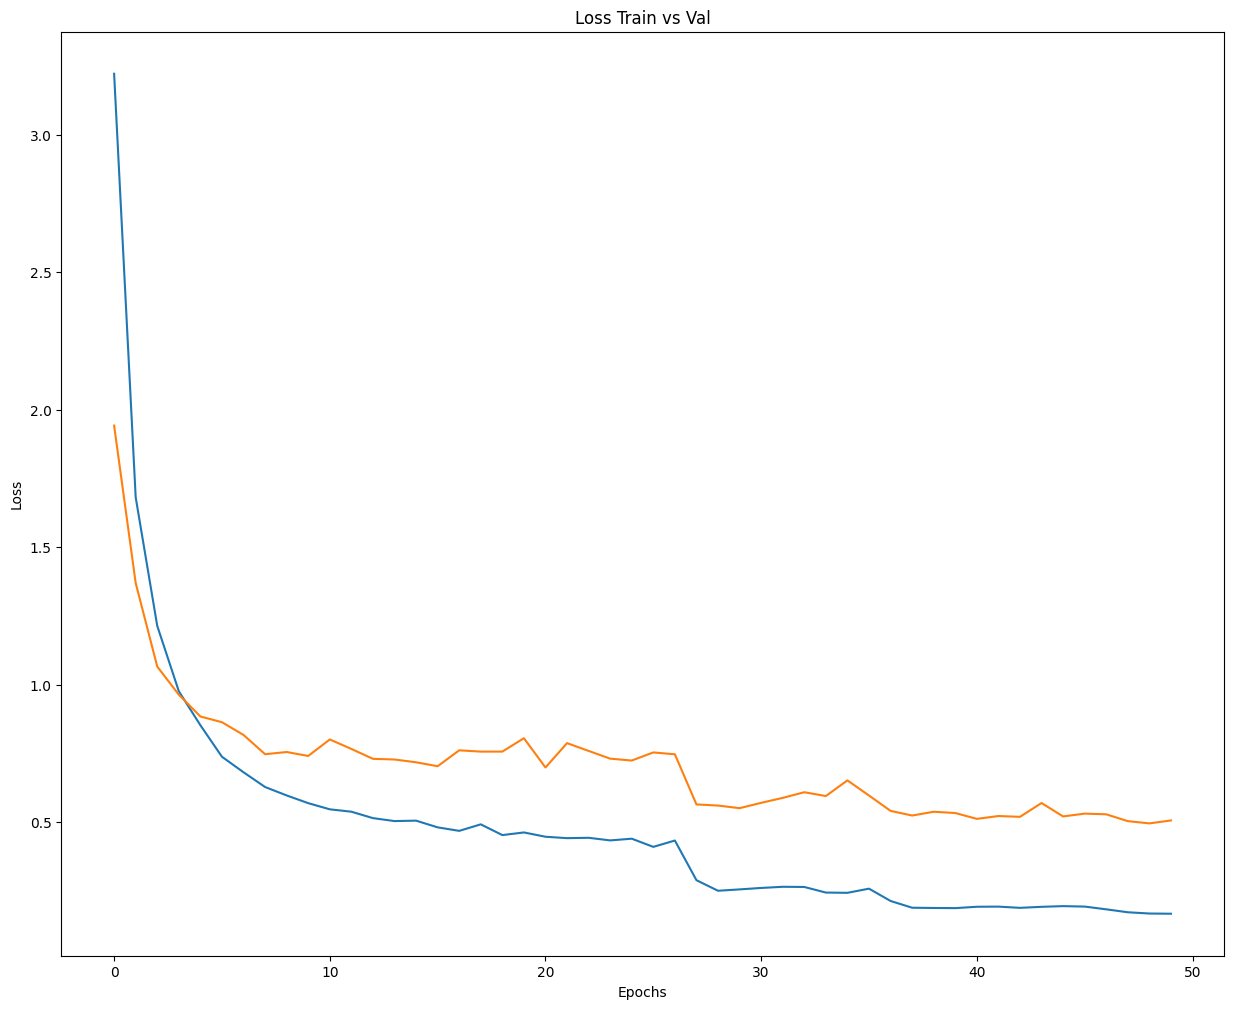

In [33]:
plt.figure(figsize=(15, 12))
plt.title('Loss Train vs Val')
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.plot(val_losses)
plt.ylabel('Loss')
plt.show()

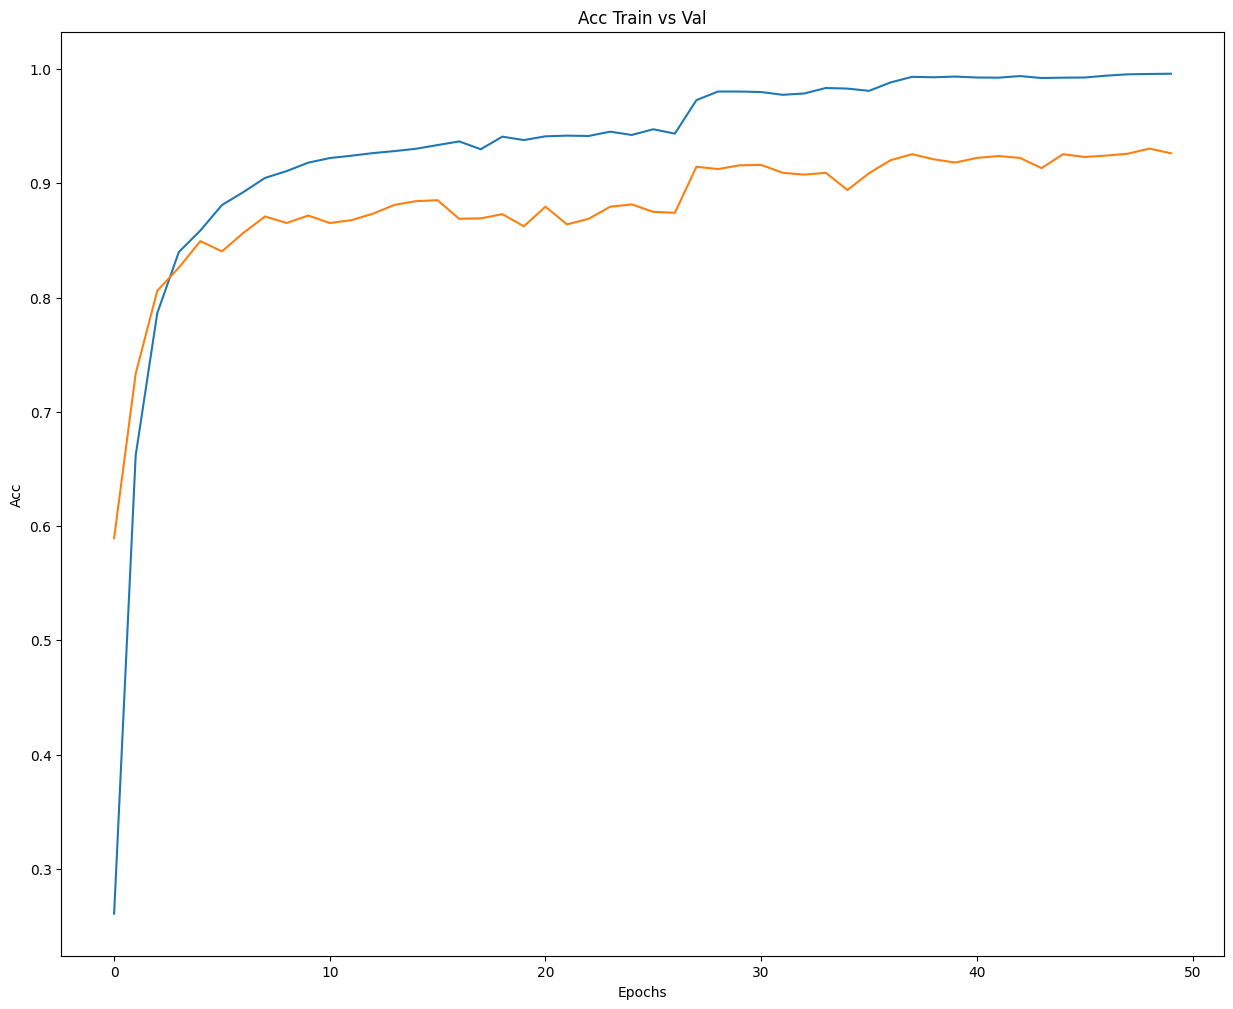

In [34]:
plt.figure(figsize=(15, 12))
plt.title('Acc Train vs Val')
plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.plot(val_accuracies)
plt.ylabel('Acc')
plt.show()

Model with ArcFace loss did an excellent job

We tried implementing ArcFace loss, now let's dive into model training with other loss called Triplet.\
For this we need to create custom dataset, which consists of triplets [anchor, positive, negative].\
Here:
 * anchor means some persons photo
 * positive means different photo of the same person
 * negative means different photo of the different person


In [51]:
class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, mode='train'):
        self.root_dir = root_dir
        self.mode = mode
        self.objects = self.get_images(root_dir)
        self.labels = self.get_labels(self.objects)
        self.triplets = self.generate_triplets()
        
    def get_labels(self, list_paths):
        labels = []
        label_to_images = {}
        for path in list_paths:
            label = os.path.basename(os.path.dirname(path))
            labels.append(label)
            if label not in label_to_images:
                label_to_images[label] = []
            label_to_images[label].append(Path(path))
        return [labels, label_to_images]

    def get_images(self, root_dir):
        images = []
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                images += [os.path.join(class_path, img) for img in os.listdir(class_path)]
        return images
    
    def __len__(self):
        return len(self.objects)
    
    def generate_triplets(self):
        triplets = []
        while len(triplets) < len(self.objects):
            label_anchor = np.random.choice(self.labels[0])
            path_anchor, path_positive = np.random.choice(self.labels[1][label_anchor], 2, replace=False)
            label_negative = np.random.choice([label for label in self.labels[0] if label != label_anchor])
            path_negative = np.random.choice(self.labels[1][label_negative])
            
            triplet = [path_anchor, path_positive, path_negative]

            if triplet not in triplets:
                triplets.append(triplet)
                
        return triplets
    
    def __getitem__(self, idx):
        path_anchor, path_positive, path_negative = self.triplets[idx]
        
        image_anchor = cv2.imread(path_anchor, cv2.IMREAD_COLOR)
        image_anchor = cv2.cvtColor(image_anchor, cv2.COLOR_BGR2RGB)
        
        image_positive = cv2.imread(path_positive, cv2.IMREAD_COLOR)
        image_positive = cv2.cvtColor(image_positive, cv2.COLOR_BGR2RGB)
        
        image_negative = cv2.imread(path_negative, cv2.IMREAD_COLOR)
        image_negative = cv2.cvtColor(image_negative, cv2.COLOR_BGR2RGB)
        
        if self.mode == 'train':
            anchor = train_transforms(image=image_anchor)['image']
            positive = train_transforms(image=image_positive)['image']
            negative = train_transforms(image=image_negative)['image']
        else:
            anchor = val_transforms(image=image_anchor)['image']
            positive = val_transforms(image=image_positive)['image']
            negative = val_transforms(image=image_negative)['image']
        
        return anchor, positive, negative


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [52]:
trainset = TripletFaceDataset(r'/kaggle/working/train', mode='train')
valset = TripletFaceDataset(r'/kaggle/working/val', mode='val')

In [53]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True,num_workers=2)
valloader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=2)

In [54]:
def show_triplet(dataloader):
    anchors, pos, neg = next(iter(dataloader))
    triplet = [anchors[0], pos[0], neg[0]]
    titles = ['anchor', 'positive', 'negative']
    fig, axs = plt.subplots(1, 3)
    axs = axs.flatten()
    for idx, ax in enumerate(axs):
        npimg = triplet[idx].numpy()
        npimg = np.transpose(npimg, (1,2,0))
        npimg = ((npimg * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])
        ax.axis('off')
        ax.title.set_text(titles[idx])
        ax.imshow(npimg, interpolation='nearest')

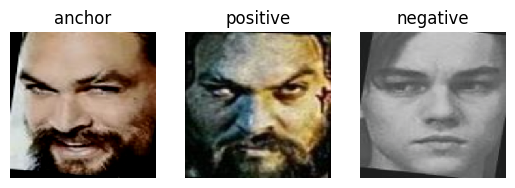

In [55]:
show_triplet(trainloader)

Here we'll define the model class. For the triplet loss we'll also use pretrained(on ImageNet) EfficientNet_b1

In [56]:
class EfficientNetTriplet(nn.Module):
    def __init__(self, embedding_size=512):
        super(EfficientNetTriplet, self).__init__()
        self.backbone = efficientnet_b1(weights='DEFAULT')
        self.backbone.classifier = nn.Identity()
        self.fc = nn.Linear(1280, embedding_size)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x

In [57]:
def train_one_epoch_triplet(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(train_loader):
        anchor_img, positive_img, negative_img = anchor_img.to(device), positive_img.to(device), negative_img.to(device)

        anchor_embeddings = model(anchor_img)
        positive_embeddings = model(positive_img)
        negative_embeddings = model(negative_img)
        
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    return train_loss

In [58]:
def validate_one_epoch_triplet(model, val_loader, criterion, device):
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (anchor_img, positive_img, negative_img) in enumerate(val_loader):
            anchor_img, positive_img, negative_img = anchor_img.to(device), positive_img.to(device), negative_img.to(device)

            anchor_embeddings = model(anchor_img)
            positive_embeddings = model(positive_img)
            negative_embeddings = model(negative_img)
           
            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(val_loader)

    return val_loss

In [59]:
def train_model_triplet(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50, early_stopping=None):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_one_epoch_triplet(model, train_loader, optimizer, criterion, device)
        
        val_loss = validate_one_epoch_triplet(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Time: {time.time() - start_time:.2f}s")

        if early_stopping and early_stopping.should_stop(val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, val_losses

In [63]:
model_triplet = EfficientNetTriplet(embedding_size=512).to(device)

criterion = nn.TripletMarginLoss(margin=0.4, p=2)
optimizer = torch.optim.Adam(
    model_triplet.parameters(), 
    lr=0.001, 
    weight_decay=1e-4
)  
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [64]:
train_losses, val_losses = train_model_triplet(model_triplet, trainloader, valloader, criterion, optimizer, 
    scheduler, device, num_epochs=50, early_stopping=early_stopping
)

Epoch [1/50] Train Loss: 0.2563, Val Loss: 0.2194, Time: 255.41s
Epoch [2/50] Train Loss: 0.2121, Val Loss: 0.1923, Time: 255.44s
Epoch [3/50] Train Loss: 0.1973, Val Loss: 0.1792, Time: 256.31s
Epoch [4/50] Train Loss: 0.1810, Val Loss: 0.1829, Time: 255.97s
Epoch [5/50] Train Loss: 0.1712, Val Loss: 0.1702, Time: 257.86s
Epoch [6/50] Train Loss: 0.1629, Val Loss: 0.1628, Time: 257.11s
Epoch [7/50] Train Loss: 0.1532, Val Loss: 0.1594, Time: 257.61s
Epoch [8/50] Train Loss: 0.1441, Val Loss: 0.1582, Time: 256.12s
Epoch [9/50] Train Loss: 0.1437, Val Loss: 0.1537, Time: 255.87s
Epoch [10/50] Train Loss: 0.1374, Val Loss: 0.1516, Time: 255.81s
Epoch [11/50] Train Loss: 0.1333, Val Loss: 0.1444, Time: 256.03s
Epoch [12/50] Train Loss: 0.1274, Val Loss: 0.1575, Time: 256.08s
Epoch [13/50] Train Loss: 0.1240, Val Loss: 0.1375, Time: 257.85s
Epoch [14/50] Train Loss: 0.1203, Val Loss: 0.1342, Time: 255.42s
Epoch [15/50] Train Loss: 0.1075, Val Loss: 0.1438, Time: 255.59s
Epoch [16/50] Train

In [65]:
torch.save(model_triplet.state_dict(), 'model_triplet_b1.pth')

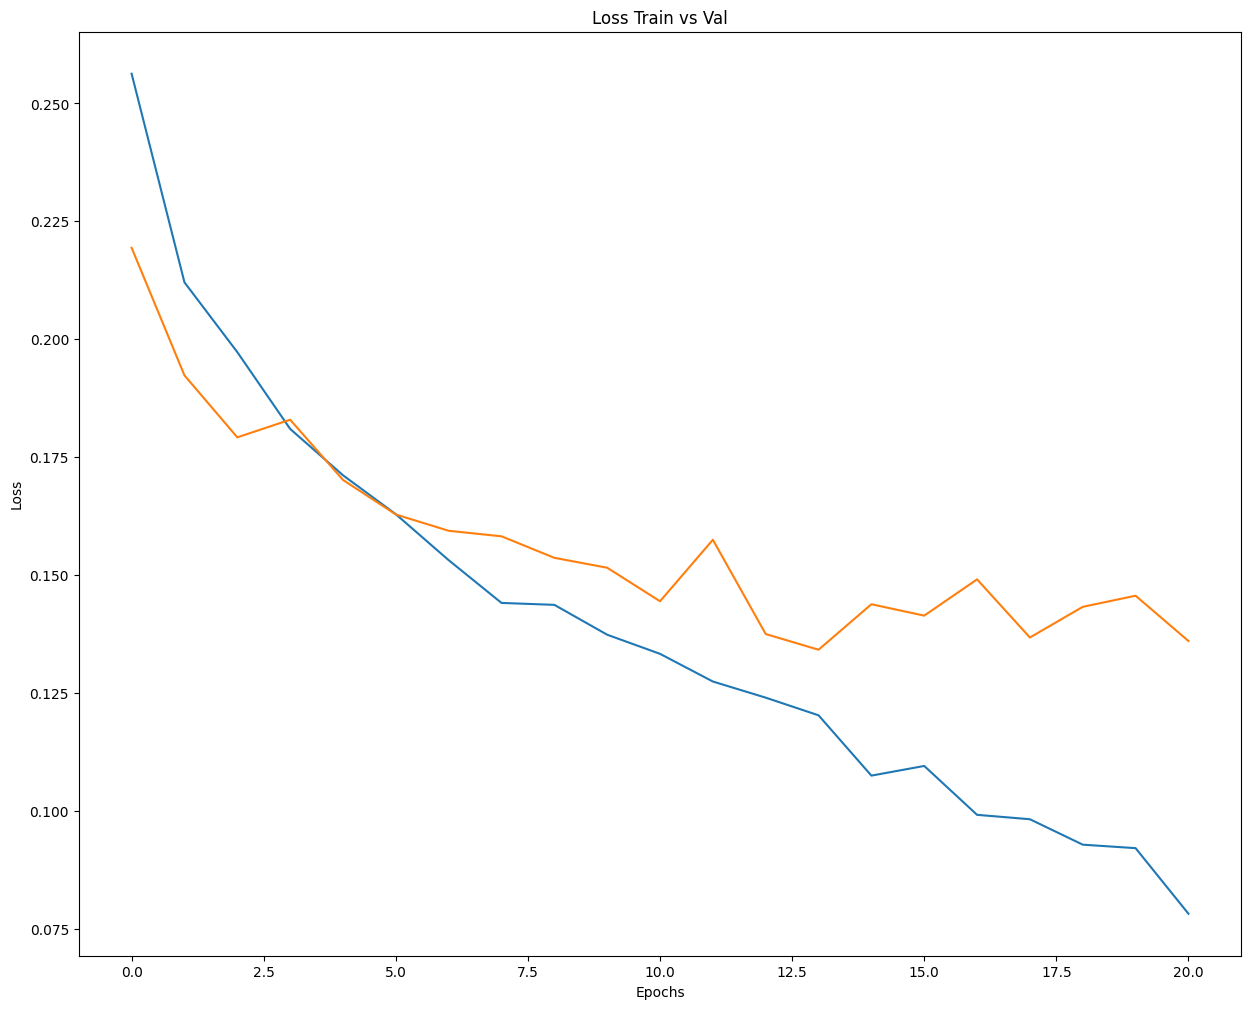

In [66]:
plt.figure(figsize=(15, 12))
plt.title('Loss Train vs Val')
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.plot(val_losses)
plt.ylabel('Loss')
plt.show()

# IDENTIFICATION RATE 

Identification rate is a metric that we'll use to evaluate our models performance.\
For this we need classes and images that model never seen, so we'll use several of the classes of this second [dataset](https://www.kaggle.com/datasets/wannad1e/celeba-500-label-folders)\
In total, we'll use 1050 photos, where 900 will be used for distractor and 150 for query

In [79]:
input_dir = '/kaggle/input/test-raw/test' 
output_dir = '/kaggle/working/test_cropped' 

os.makedirs(output_dir, exist_ok=True)

We'll perform face detection and face alignment here for the new images

In [80]:
for person_folder in os.listdir(input_dir):
    person_dir = os.path.join(input_dir, person_folder)
    
    if os.path.isdir(person_dir):
        person_output_dir = os.path.join(output_dir, person_folder)
        os.makedirs(person_output_dir, exist_ok=True)

        for image_name in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_name)

            image = Image.open(image_path)
            image_np = np.array(image)

            boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

            if boxes is not None:
                for i, box in enumerate(boxes):
                    box = box.astype(int)   
                    cropped_face = image_np[box[1]:box[3], box[0]:box[2]]
                    
                    try:
                        aligned_image_np = align_face(cropped_face, landmarks[i])
                    except:
                        continue
                        
                    cropped_aligned_face_pil = Image.fromarray(aligned_image_np)

                    aligned_face_path = os.path.join(person_output_dir, f'aligned_{image_name}')
                    try:
                        cropped_aligned_face_pil.save(aligned_face_path)
                    except:
                        continue

Now we need to split images for distractor and query

In [82]:
root_dir = '/kaggle/input/test-cropped-latest'   
query_output_dir = '/kaggle/working/query_set' 
distractor_output_dir = '/kaggle/working/distractor_set'

query_ratio_per_class = 0.15   
distractor_ratio = 0.85      

os.makedirs(query_output_dir, exist_ok=True)
os.makedirs(distractor_output_dir, exist_ok=True)

class_folders = os.listdir(root_dir)
query_set_classes = random.sample(class_folders, int(len(class_folders) * query_ratio_per_class))

for class_folder in class_folders:
    class_path = os.path.join(root_dir, class_folder)
    
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        num_images = len(images)
        
        if class_folder in query_set_classes:
            query_images = random.sample(images, num_images)
            
            class_query_dir = os.path.join(query_output_dir, class_folder)
            os.makedirs(class_query_dir, exist_ok=True)
            
            for img in query_images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(class_query_dir, img)
                shutil.copy(src_path, dst_path)
        
        else:
            class_distractor_dir = os.path.join(distractor_output_dir, class_folder)
            os.makedirs(class_distractor_dir, exist_ok=True)
            
            for img in images:
                src_path = os.path.join(class_path, img)
                dst_path = os.path.join(class_distractor_dir, img)
                shutil.copy(src_path, dst_path)

print("Query and Distractor sets created successfully!")

Query and Distractor sets created successfully!


Here are all the functions to calculate id rate metric

In [67]:
def extract_embeddings(model, image_paths, device, criterion='ArcFace'):
    model.eval()
    embeddings = []
    if criterion != 'ArcFace':
        with torch.no_grad():
            for image_path in image_paths:
                try:
                    image = Image.open(image_path).convert('RGB')
                except:
                    continue
                image = transform(image).unsqueeze(0).to(device)  
                embedding = model(image) 
                embeddings.append(embedding.cpu().numpy())
    else:
        with torch.no_grad():
            for image_path in image_paths:
                try:
                    image = Image.open(image_path).convert('RGB')
                except:
                    continue
                image = transform(image).unsqueeze(0).to(device)  
                features = model.feature_extractor(image)
                features = model.fc(features)
                embeddings.append(features.cpu().numpy())
    embeddings = np.vstack(embeddings)
    return embeddings

In [68]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [69]:
def cosine_similarity(embeddings1, embeddings2=None):
    if embeddings2 is None:
        embeddings2 = embeddings1
    
    embeddings1_tensor = torch.tensor(np.array(embeddings1), dtype=torch.float32)
    embeddings2_tensor = torch.tensor(np.array(embeddings2), dtype=torch.float32)

    embeddings1_norm = F.normalize(embeddings1_tensor, dim=1)
    embeddings2_norm = F.normalize(embeddings2_tensor, dim=1)

    cos_sim = torch.mm(embeddings1_norm, embeddings2_norm.T)
    
    return cos_sim

In [70]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    ans = []
    with torch.no_grad():
        for key, values in query_dict.items():       
            start = query_img_names.index(values[0]) 
            end = query_img_names.index(values[len(values) - 1])

            cos_dist = cosine_similarity(query_embeddings[start:end + 1])
            mask = np.zeros_like(cos_dist, dtype=bool)
            mask[np.triu_indices_from(mask)] = True
            mask = mask.flatten()
            ans.extend(np.delete(cos_dist, mask))
            del cos_dist

    return ans

In [71]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    ans = []
    end = len(query_img_names) - 1       
    with torch.no_grad():
        for key, values in query_dict.items():
            start = query_img_names.index(values[len(values) - 1]) + 1 
            if start >= end:
                break
            arr_evl = query_embeddings[start:end + 1] 
            for i in range(len(values)):
                aux = query_img_names.index(values[i]) 
                cos_dist = cosine_similarity(arr_evl, [query_embeddings[aux]]) 
                ans.extend(cos_dist.flatten()) 
                del cos_dist
            del arr_evl

    return ans

In [72]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    with torch.no_grad():
        cos_dist = cosine_similarity(query_embeddings, distractors_embeddings)

    return list(cos_dist.flatten())

In [73]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.15):
    false_pairs = cosine_query_neg + cosine_query_distractors 
    N = int(fpr * len(false_pairs))
    threshold = np.sort(false_pairs)[::-1][N]
    filtred = list(filter(lambda x: x >= threshold, cosine_query_pos))
    tpr = len(filtred)/len(cosine_query_pos)

    return threshold, tpr

In [74]:
def get_model_id_rate(model, query_dir, distractor_dir, criterion):
    model = model.to(device)
    model.eval()

    query_image_paths = []
    query_dict = {}  
    query_img_names = []
    for class_folder in os.listdir(query_dir):
        class_path = os.path.join(query_dir, class_folder)
        if os.path.isdir(class_path):
            query_dict[class_folder] = []
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                query_image_paths.append(img_path)
                query_dict[class_folder].append(img_name)
                query_img_names.append(img_name)

    distractor_image_paths = []
    distractor_dict = {}  
    distractor_img_names = []
    for class_folder in os.listdir(distractor_dir):
        class_path = os.path.join(distractor_dir, class_folder)
        if os.path.isdir(class_path):
            distractor_dict[class_folder] = []
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                distractor_image_paths.append(img_path)
                distractor_dict[class_folder].append(img_name)
                distractor_img_names.append(img_name)

    query_embeddings = extract_embeddings(model, query_image_paths, device, criterion=criterion)

    distractor_embeddings = extract_embeddings(model, distractor_image_paths, device, criterion=criterion)

    cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)
    cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)
    cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractor_embeddings)

    threshold, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors)
    print(f"Threshold: {threshold}, True Positive Rate (Identification Rate): {tpr}")

In [76]:
query_dir = '/kaggle/input/id-rate-dataset/query_cropped'
distractor_dir = '/kaggle/input/id-rate-dataset/distractor_cropped'

Let's compute id rate for model with CE loss

In [32]:
model_ce_results = efficientnet_b1(weights=None)
model_ce_results.classifier[1] = nn.Linear(model_ce_results.classifier[1].in_features, n_individuals) 

model_ce_results.load_state_dict(torch.load('/kaggle/input/b1_model_ce_loss/pytorch/default/1/model_ce_b1.pth'))

get_model_id_rate(model_ce_results, query_dir, distractor_dir, 'CE')

Threshold: 0.46107468008995056, True Positive Rate (Identification Rate): 0.8018154311649016


Let's compute id rate for model with ArcFace loss

In [36]:
model_arcface_results = EfficientNetFaceRecognition(num_classes=num_classes)

model_arcface_results.load_state_dict(torch.load('/kaggle/input/arcface_model_b1/pytorch/default/1/model_arkface_b1.pth'))

get_model_id_rate(model_arcface_results, query_dir, distractor_dir, 'ArcFace')

Threshold: 0.15486058592796326, True Positive Rate (Identification Rate): 0.7276853252647504


Let's compute id rate for model with Triplet loss

In [77]:
model_triplet_results = EfficientNetTriplet(embedding_size=512)

model_triplet_results.load_state_dict(torch.load('/kaggle/input/triplet_new/pytorch/default/1/model_triplet_b1.pth'))

get_model_id_rate(model_triplet_results, query_dir, distractor_dir, 'Triplet')

Threshold: 0.8601330518722534, True Positive Rate (Identification Rate): 0.5416036308623298


# FACE RECOGNITION PIPELINE

In this part we'll assemble the whole pipeline together.\
It will accept raw photo as input -> perform face detection & alignment(using pretrained MTCNN) -> perform feature extraction(using selected model from the list) -> give output(top pictures, that are most simular to the input, based on the cosine simularities of embeddings)

The face recognition part will be performed the next way:
1. We'll extract embedding for input image.
2. We calculate avg embedding for 20 images from each class.
3. Using cosine simularity we'll get closest to the input image classes.(Embeddings are represented as vectors, thus the more 2 people are simular to each other, the closer their vectors would be in coordinate system, and visa verse).

Here are the photos that we'll use for demonstration

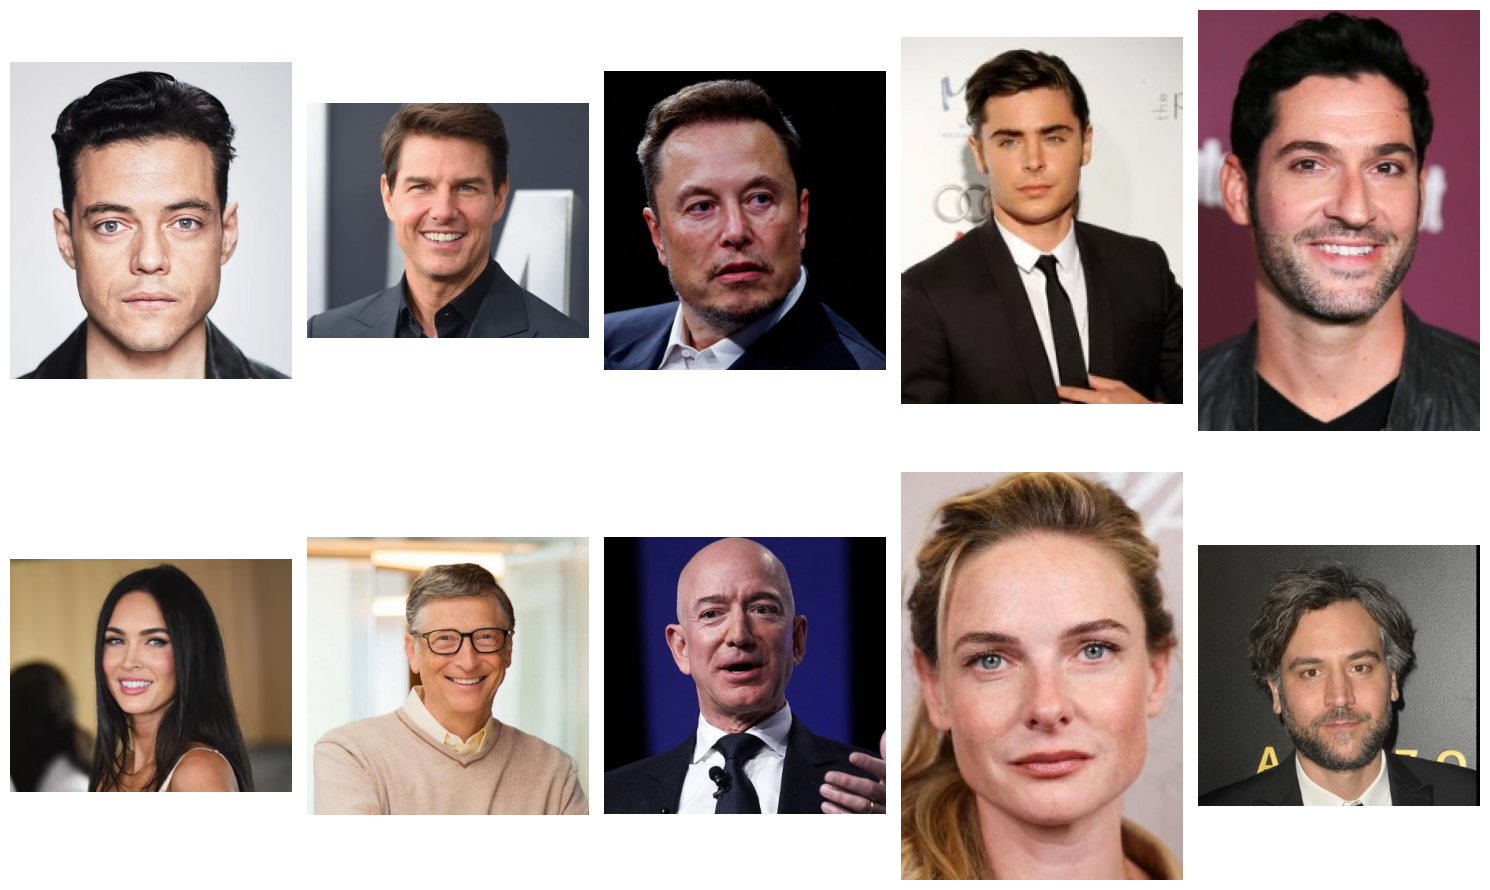

In [127]:
folder_path = '/kaggle/input/demo-dataset/demo'
image_files = os.listdir(folder_path)
fig, axs = plt.subplots(2, 5, figsize=(15, 10))

for idx, image_file in enumerate(image_files):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path)
    row = idx // 5
    col = idx % 5
    axs[row, col].imshow(img)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

I won't display image for every model demo, cause they will be used in the order shown above.

In [78]:
def face_recognition_pipeline(pretrained=False, criterion='CE'):
    input_dir = '/kaggle/input/demo-dataset/demo'
    original_dataset_dir = '/kaggle/input/cropped-dataset-latest'
    
    if not pretrained and criterion == 'CE':
        model = efficientnet_b1(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, n_individuals) 
        model.load_state_dict(torch.load('/kaggle/input/b1_model_ce_loss/pytorch/default/1/model_ce_b1.pth'))
    elif not pretrained and criterion == 'ArcFace':
        model = EfficientNetFaceRecognition(num_classes=num_classes)
        model.load_state_dict(torch.load('/kaggle/input/arcface_model_b1/pytorch/default/1/model_arkface_b1.pth'))
    elif not pretrained and criterion == 'Triplet':
        model = EfficientNetTriplet(embedding_size=512)
        model.load_state_dict(torch.load('/kaggle/input/triplet_new/pytorch/default/1/model_triplet_b1.pth'))
    elif pretrained:
        model = InceptionResnetV1(pretrained='vggface2')
    model = model.to(device)
    model.eval()
        
    def extract_features(img_cropped_aligned, model):
        img = transform(img_cropped_aligned).unsqueeze(0) 
        with torch.no_grad():
            img = img.to(device)
            if criterion != 'ArcFace':
                features = model(img)
            else:
                features = model.feature_extractor(img)
                features = model.fc(features)  
            embedding = F.normalize(features, p=2, dim=1)
        return embedding.cpu().squeeze().numpy()
    
    # function to create an average reference embedding for each class
    def create_reference_embeddings(dataset_dir, model, transform, num_images=20):
        class_folders = os.listdir(dataset_dir)
        reference_embeddings = {}

        for class_folder in class_folders:
            class_path = os.path.join(dataset_dir, class_folder)
            images = os.listdir(class_path)
            selected_images = random.sample(images, num_images) 

            embeddings = []
            for img in selected_images:
                img_path = os.path.join(class_path, img)
                img = Image.open(img_path).convert('RGB') 
                embedding = extract_features(img, model)
                embeddings.append(embedding)

            avg_embedding = np.mean(embeddings, axis=0)
            reference_embeddings[class_folder] = avg_embedding

        return reference_embeddings
    
    # get avg embeddings for each clas
    reference_embeddings = create_reference_embeddings(original_dataset_dir, model, transform)
    
    for image in os.listdir(input_dir):
        
        # acquire image path
        img_path = os.path.join(input_dir, image)

        # perform face detection and face alignment
        img_cropped_aligned = display_aligned_cropped(img_path, show_result=False)
        
        # use selected model to perform feature extraction
        input_embedding = extract_features(Image.fromarray(img_cropped_aligned), model)

        # compare input image embedding to reference embeddings using cosine similarity
        similarities = []
        class_names = []
        for class_name, ref_embedding in reference_embeddings.items():
            similarity = cosine_similarity([input_embedding], [ref_embedding])[0][0]
            similarities.append(similarity)
            class_names.append(class_name)

        # identify the class with the highest similarity score
        max_sim_idx = np.argmax(similarities)
        identified_class = class_names[max_sim_idx]
        similarity_score = similarities[max_sim_idx]

        print(f"Input image name: {image},    Identified Class: {identified_class},    Similarity Score: {similarity_score:.4f}")

Let's evaluate model with CE loss

In [38]:
face_recognition_pipeline(pretrained=False, criterion='CE')

Input image name: RamiMalek.jpg,    Identified Class: pins_Rami Malek,    Similarity Score: 0.9018
Input image name: TomCruise.jpg,    Identified Class: pins_Tom Cruise,    Similarity Score: 0.9111
Input image name: ElonMusk.jpg,    Identified Class: pins_elon musk,    Similarity Score: 0.8327
Input image name: ZacEfron.jpg,    Identified Class: pins_Zac Efron,    Similarity Score: 0.8851
Input image name: TomEllis.jpg,    Identified Class: pins_tom ellis,    Similarity Score: 0.8697
Input image name: MeganFox.jpg,    Identified Class: pins_Megan Fox,    Similarity Score: 0.6852
Input image name: BillGates.jpg,    Identified Class: pins_Bill Gates,    Similarity Score: 0.7534
Input image name: JeffBezos.jpg,    Identified Class: pins_jeff bezos,    Similarity Score: 0.8979
Input image name: RebeccaFerguson.jpg,    Identified Class: pins_Rebecca Ferguson,    Similarity Score: 0.7627
Input image name: JoshRadnor.jpg,    Identified Class: pins_Josh Radnor,    Similarity Score: 0.9125


As we can see, model with CE loss performed excellently 

Let's evaluate model with ArcFace loss

In [39]:
face_recognition_pipeline(pretrained=False, criterion='ArcFace')

Input image name: RamiMalek.jpg,    Identified Class: pins_Rami Malek,    Similarity Score: 0.9997
Input image name: TomCruise.jpg,    Identified Class: pins_Tom Cruise,    Similarity Score: 0.9995
Input image name: ElonMusk.jpg,    Identified Class: pins_elon musk,    Similarity Score: 0.9986
Input image name: ZacEfron.jpg,    Identified Class: pins_Zac Efron,    Similarity Score: 0.9964
Input image name: TomEllis.jpg,    Identified Class: pins_tom ellis,    Similarity Score: 0.9989
Input image name: MeganFox.jpg,    Identified Class: pins_Megan Fox,    Similarity Score: 0.9468
Input image name: BillGates.jpg,    Identified Class: pins_Bill Gates,    Similarity Score: 0.9991
Input image name: JeffBezos.jpg,    Identified Class: pins_jeff bezos,    Similarity Score: 0.9993
Input image name: RebeccaFerguson.jpg,    Identified Class: pins_Rebecca Ferguson,    Similarity Score: 0.9953
Input image name: JoshRadnor.jpg,    Identified Class: pins_Josh Radnor,    Similarity Score: 0.9994


As we can see, ArcFace also did great

Let's evaluate model with Triplet loss

In [79]:
face_recognition_pipeline(pretrained=False, criterion='Triplet')

Input image name: RamiMalek.jpg,    Identified Class: pins_Rami Malek,    Similarity Score: 0.9948
Input image name: TomCruise.jpg,    Identified Class: pins_Pedro Alonso,    Similarity Score: 0.9942
Input image name: ElonMusk.jpg,    Identified Class: pins_Tom Hiddleston,    Similarity Score: 0.9859
Input image name: ZacEfron.jpg,    Identified Class: pins_Rami Malek,    Similarity Score: 0.9706
Input image name: TomEllis.jpg,    Identified Class: pins_Chris Hemsworth,    Similarity Score: 0.9915
Input image name: MeganFox.jpg,    Identified Class: pins_Inbar Lavi,    Similarity Score: 0.9854
Input image name: BillGates.jpg,    Identified Class: pins_Mark Zuckerberg,    Similarity Score: 0.9959
Input image name: JeffBezos.jpg,    Identified Class: pins_jeff bezos,    Similarity Score: 0.9869
Input image name: RebeccaFerguson.jpg,    Identified Class: pins_Madelaine Petsch,    Similarity Score: 0.9878
Input image name: JoshRadnor.jpg,    Identified Class: pins_Chris Hemsworth,    Simil

As for the model with the Triplet loss, it failed miserably. Here are some reasons why could this happen:
* triplets were not well chosen during training
* model may collapsed the embedding space where all embeddings become too close to each other
* the amount of data also may be not large enought for this type of loss function

Also, for demonstration purposes, let's check how well more complicated pretrained model would perform 

In [80]:
face_recognition_pipeline(pretrained=True)

  0%|          | 0.00/107M [00:00<?, ?B/s]

Input image name: RamiMalek.jpg,    Identified Class: pins_Rami Malek,    Similarity Score: 0.7657
Input image name: TomCruise.jpg,    Identified Class: pins_Tom Cruise,    Similarity Score: 0.6959
Input image name: ElonMusk.jpg,    Identified Class: pins_elon musk,    Similarity Score: 0.7617
Input image name: ZacEfron.jpg,    Identified Class: pins_Zac Efron,    Similarity Score: 0.8280
Input image name: TomEllis.jpg,    Identified Class: pins_tom ellis,    Similarity Score: 0.6972
Input image name: MeganFox.jpg,    Identified Class: pins_Megan Fox,    Similarity Score: 0.8342
Input image name: BillGates.jpg,    Identified Class: pins_Bill Gates,    Similarity Score: 0.8088
Input image name: JeffBezos.jpg,    Identified Class: pins_jeff bezos,    Similarity Score: 0.8371
Input image name: RebeccaFerguson.jpg,    Identified Class: pins_Rebecca Ferguson,    Similarity Score: 0.7902
Input image name: JoshRadnor.jpg,    Identified Class: pins_Josh Radnor,    Similarity Score: 0.6380


Obviously, pretrained InceptionResnet model performed perfectly

Conclusion:\
We created the solution for the face recognition task, which includes 4 steps:
* face detection
* face alignment
* feature extraction
* face recognition

For the feature extraction part we experimented with several loss functions such as default CE, ArcFace, Triplet. Among them, CE showed the best result on Identification rate metric.

As for the demonstration part, every model except the one with Triplet loss performed perfrectly